# **Brain complexities and anesthesia**

Complexity metrics are increasingly being used to analyse EEG signals in anesthesia. This notebook guides the reader through a few examples illustrating methodological points related to time-series and spatial complexity. Specifically, we will learn how to compute different complexity metrics in Python and consider properties of signals that affect their complexity.

We will utilize the [AntroPy toolbox](https://raphaelvallat.com/antropy/) to compute most complexity metrics. Other alternatives include [NeuroKit](https://neurokit2.readthedocs.io/en/latest/examples/complexity.html) in Python and user-contributed Matlab libraries (e.g. [RangeEn](https://www.mathworks.com/matlabcentral/fileexchange/69850-signal-complexity-analysis)).

For more discussion of various complexity metrics and their meaning, please see the publication associated with this notebook:

*Li, Fabus, and Sleigh (2021) - Brain complexities and anesthesia: their meaning and measurement ([DOI: xxx](http://google.com)).*

This notebook uses the following modules: [numpy](https://numpy.org/install/), [matplotlib](https://matplotlib.org/stable/users/installing/index.html), [antropy](https://raphaelvallat.com/antropy/), and [MNE](https://mne.tools/stable/install/index.html). In order for this notebook to work interactively, you may need to install these (e.g. using Anaconda or pip). More information on installation can be found on the website of each of the listed packages.

**Contents:**
1. [Time-series complexity](#time-series)
    - Signal simulation and AntroPy basics
    - Signal properties affecting complexity - frequency, noise, waveform shape
    - Summary
2. [Spatial complexity](#spatial)
    - Functional connectivity matrices
    - Singular value decomposition (SVD)

## 1. Time-series complexity <a name="time-series"></a>
### Signal simulation and AntroPy basics

Let's start by importing relevant libraries and creating a simulated 10Hz signal with some noise.

(0.0, 1.0)

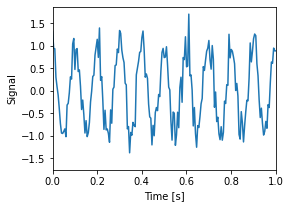

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import antropy as ant

# Create a simple oscillatory signal with some noise
sample_rate = 200 #Hz
Nsec = 10 #s
f0 = 10 #Hz
time_vect = np.linspace(0, Nsec, Nsec*sample_rate)
noise = np.random.normal(0, 0.25, len(time_vect))
x = np.cos(2*np.pi*f0*time_vect) + noise

# Plot signal
plt.figure(figsize=(4, 3))
plt.plot(time_vect, x)
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.xlim(0, 1)

We can evaluate different complexity metrics on this simulated signal by calling AntroPy (ant). For example, we can call different entropy metrics:

In [2]:
# Permutation entropy
print('PE = ', ant.perm_entropy(x, normalize=True))

# Approximate entropy
print('AE = ', ant.app_entropy(x))

# Sample entropy
print('SE = ', ant.sample_entropy(x))

PE =  0.9686654505457826
AE =  1.5295455185792277
SE =  1.49428743350983


If we are interested in the Lempel-Ziv complexity, we need to binarise the signal before calling the relevant function. Here we threshold the signal by the mean value.

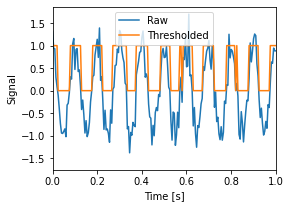

In [3]:
# Create a binarized version of the signal
x_bin = x.copy()*0
thr = np.mean(x)
x_bin[np.where(x >= thr)] = 1

# Plot signal
plt.figure(figsize=(4, 3))
plt.plot(time_vect, x, label='Raw')
plt.plot(time_vect, x_bin, label='Thresholded')
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.xlim(0, 1)
plt.legend()

We can now compute LZC, here normalised to account for sequence length (as per https://doi.org/10.1007/s10910-008-9512-2).

In [4]:
ant.lziv_complexity(x_bin, normalize=True)

0.3180077442552005

### Signal properties affecting complexity

Now that we've seen how to use example complexity functions, let's explore how changing the signal affects its complexity. 

#### Signal frequency
We will take a chirp signal, a sinusoid increasing in frequency, that sweeps between 0.5Hz and 5Hz in 40 seconds. We will take 10 second windows (9s overlap) as we track changes in permutation entropy and Lempel-Ziv complexity.

(-2.0, 42.0, -1.0999998332451333, 1.0999999357359773)

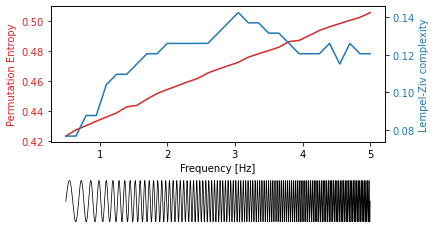

In [172]:
chirp_complexity = np.zeros((2, 31))
freqs = np.linspace(0.5, 5, 31)

# Define chirp signal
Nsec = 40
time_vect = np.linspace(0, Nsec, Nsec*sample_rate)
f0 = 0.5
c = (5-f0)/Nsec
Xchirp = np.sin(2*np.pi*(f0+c*time_vect/2)*time_vect)

# Split signal into overlapping windows
x_seg = np.lib.stride_tricks.sliding_window_view(Xchirp, 10*sample_rate)[::sample_rate, :]

# Loop over frequencies between 0.1Hz and 10Hz
for i in range(x_seg.shape[0]):
    x = x_seg[i, :]
    PE = ant.perm_entropy(x, normalize=True)
    
    x_bin = x.copy()*0
    thr = np.mean(x)
    x_bin[np.where(x >= thr)] = 1
    LZ = ant.lziv_complexity(x_bin, normalize=True)
    
    chirp_complexity[0, i] = PE
    chirp_complexity[1, i] = LZ

# Plot the results
fig, (ax1, ax3) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.4)
color = 'tab:red'
ax1.plot(freqs, chirp_complexity[0, :],  color=color)
ax1.set_ylabel('Permutation Entropy', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Frequency [Hz]')

color = 'tab:blue'
ax2 = ax1.twinx() 
ax2.plot(freqs, chirp_complexity[1, :], color=color)
ax2.set_ylabel('Lempel-Ziv complexity', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3.plot(time_vect, Xchirp, lw=0.75, color='k')
ax3.axis('off')

We can see both measures increase as frequency increases, PE almost linearly and LZC in a more complicated fashion. 


Let's try the same thing for an oscillatory signal with noise of increasing amplitude (i.e. signal with decreasing signal-to-noise ratio).

(-2.0, 42.0, -1.7705237899178043, 1.7655798288310565)

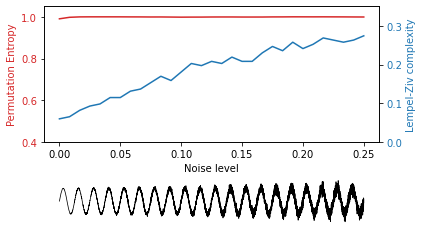

In [173]:
snr_complexity = np.zeros((2, 31))
noise_rms = np.linspace(0., 0.25, 31)

# Define signal with linearly increasing noise level
Nsec = 40
time_vect = np.linspace(0, Nsec, Nsec*sample_rate)
f0 = 0.5
Xsnr = np.sin(2*np.pi*f0*time_vect)

noise = np.random.normal(0, 0.25, Nsec*sample_rate)
noise *= np.linspace(0, 1, Nsec*sample_rate)

Xsnr += noise

# Split signal into overlapping windows
x_seg = np.lib.stride_tricks.sliding_window_view(Xsnr, 10*sample_rate)[::sample_rate, :]

# Loop over noise levels
for i in range(x_seg.shape[0]):
    x = x_seg[i, :]
    PE = ant.perm_entropy(x, normalize=True)
    
    x_bin = x.copy()*0
    thr = np.mean(x)
    x_bin[np.where(x >= thr)] = 1
    LZ = ant.lziv_complexity(x_bin, normalize=True)
    
    snr_complexity[0, i] = PE
    snr_complexity[1, i] = LZ

# Plot the results
fig, (ax1, ax3) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.4)
color = 'tab:red'
ax1.plot(noise_rms, snr_complexity[0, :],  color=color)
ax1.set_ylabel('Permutation Entropy', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Noise level')
ax1.set_ylim(0.4, 1.05)

color = 'tab:blue'
ax2 = ax1.twinx() 
ax2.plot(noise_rms, snr_complexity[1, :], color=color)
ax2.set_ylabel('Lempel-Ziv complexity', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 0.35)

ax3.plot(time_vect, Xsnr, lw=0.75, color='k')
ax3.axis('off')

LZ increases nearly linearly with increasing noise level (5-fold increase!), whereas permutation entropy is almost unchanged. 

### Waveform shape
Finally, consider a waveform which gets progressively more non-sinusoidal as harmonics are added to it.

(-2.0, 42.0, -1.0999998168267895, 1.0999999710779136)

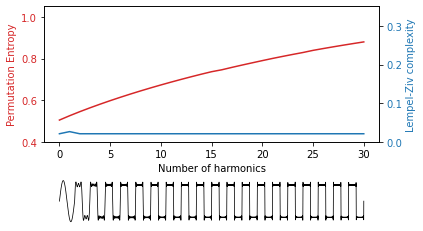

In [174]:
wf_complexity = np.zeros((2, 31))
nharm = np.arange(31)

# Define signal with progressively more harmonics
Nsec = 40
time_vect = np.linspace(0, Nsec, Nsec*sample_rate)
f0 = 0.5
X0 = np.sin(2*np.pi*f0*time_vect)
X1 = 1/3 * np.sin(2*np.pi*3*f0*time_vect)
X2 = 1/5 * np.sin(2*np.pi*5*f0*time_vect)

def square_wave(Nharm, base):
    out = base.copy()
    for h in range(1, Nharm+1):
        out += 1/(2*h+1) * np.sin(2*np.pi*(2*h+1)*f0*time_vect)
    return out

X = X0.copy()
for i in range(0, 40, 2):
    X[i*sample_rate:(i+2)*sample_rate] = square_wave(i, X0)[i*sample_rate:(i+2)*sample_rate]

# Split signal into overlapping windows
x_seg = np.lib.stride_tricks.sliding_window_view(X, 10*sample_rate)[::sample_rate, :]

# Loop over signal
for i in range(x_seg.shape[0]):
    x = x_seg[i, :]
    PE = ant.perm_entropy(x, normalize=True)
    
    x_bin = x.copy()*0
    thr = np.mean(x)
    x_bin[np.where(x >= thr)] = 1
    LZ = ant.lziv_complexity(x_bin, normalize=True)
    
    wf_complexity[0, i] = PE
    wf_complexity[1, i] = LZ

# Plot the results
fig, (ax1, ax3) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace=0.4)
color = 'tab:red'
ax1.plot(nharm, wf_complexity[0, :],  color=color)
ax1.set_ylabel('Permutation Entropy', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Number of harmonics')
ax1.set_ylim(0.4, 1.05)

color = 'tab:blue'
ax2 = ax1.twinx() 
ax2.plot(nharm, wf_complexity[1, :], color=color)
ax2.set_ylabel('Lempel-Ziv complexity', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 0.35)
ax3.plot(time_vect, X, lw=0.75, color='k')
ax3.axis('off')

We can see permutation entropy increases as more frequency content is introduced, whereas LZ is virtually unchanged.

### Summary
Finally, we plot all the above results together for convenience.

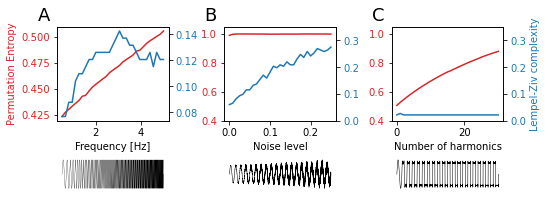

In [190]:
# Plot the results
fig, axs = plt.subplots(2, 3, gridspec_kw={'height_ratios': [3, 1]},
                       figsize=(8, 3))
plt.subplots_adjust(hspace=0.6, wspace=0.5)

# Frequency
ax1 = axs[0][0]
ax3 = axs[1][0]

color = 'tab:red'
ax1.plot(freqs, chirp_complexity[0, :],  color=color)
ax1.set_ylabel('Permutation Entropy', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Frequency [Hz]')

color = 'tab:blue'
ax2 = ax1.twinx() 
ax2.plot(freqs, chirp_complexity[1, :], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('A                        ', fontsize=18)

ax3.plot(time_vect, Xchirp, lw=0.25, color='k')
ax3.axis('off')

# Noise level
ax1 = axs[0][1]
ax3 = axs[1][1]

color = 'tab:red'
ax1.plot(noise_rms, snr_complexity[0, :],  color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Noise level')
ax1.set_ylim(0.4, 1.05)

color = 'tab:blue'
ax2 = ax1.twinx() 
ax2.plot(noise_rms, snr_complexity[1, :], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 0.35)
ax2.set_title('B                        ', fontsize=18)

ax3.plot(time_vect, Xsnr, lw=0.5, color='k')
ax3.axis('off')

# Harmonics
ax1 = axs[0][2]
ax3 = axs[1][2]

color = 'tab:red'
ax1.plot(nharm, wf_complexity[0, :],  color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Number of harmonics')
ax1.set_ylim(0.4, 1.05)

color = 'tab:blue'
ax2 = ax1.twinx() 
ax2.plot(nharm, wf_complexity[1, :], color=color)
ax2.set_ylabel('Lempel-Ziv complexity', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 0.35)
ax2.set_title('C                        ', fontsize=18)
ax3.plot(time_vect, X, lw=0.5, color='k')
ax3.axis('off')


# If saving the figure
plt.savefig('MethodsFig2.png', bbox_inches='tight', dpi=300, transparent=False,
           facecolor='w')


In summary, we have seen the following changes:

|            | Frequency increase | Noise increase | Waveform more non-sinusoidal |
|:----------:|:------------------:|:--------------:|:----------------------------:|
|   Entropy  |          ↑         |        -       |               ↑              |
| Lempel-Ziv |          ↑         |        ↑       |               -              |

We can see different complexity metrics are often affected by different signal properties. It is therefore good practice to try a range of metrics on one's data. The properties considered here are not the only ones that affect complexity metrics. A few more to keep in mind are segment length, noise bandwidth, and non-linear properties such as stochastic variability in the waveform shape. For more details, see our accompanying publication.

## 2. Spatial complexity <a name="spatial"></a>
We have seen how to evaluate complexity of single-channel time-series. In anesthesia research, we are often interested in measuring activity of different brain regions and collect multi-channel data. In this section, we outline how an example complexity analysis pipeline may look in this case. Specifically, we look at *spatial* complexity. In this approach, we see the brain as a network of interacting regions, and evaluate changes in complexity of this network.

### Functional connectivity matrices 
The first step is to construct a network of connected brain regions. Many metrics exist to evaluate functional connectivity between a pair of channels, e.g. amplitude envelope correlation or the phase lag index. Here, we will use the imaginary coherence (imCoh) implemented in the [MNE-Python](https://mne.tools/stable/) toolbox. The network is represented by an N x N matrix, where N is the number of channels and the element $(i, j)$ represents the connection strength between channels $i$ and $j$.

For simplicity, let's consider network matrices of 3 brain regions in the following cases: 1) a perfectly connected network, 2) a perfectly independent network, and 3) an intermediate case. 

In [161]:
import mne
np.random.seed(1)

sample_rate = 200 #Hz
Nsec = 10 #s
f0 = 10 #Hz
time_vect = np.linspace(0, Nsec, Nsec*sample_rate)

# Case 1: perfectly connected network
# Simulate signal
Fz = np.cos(2*np.pi*f0*time_vect)
Cz = np.cos(2*np.pi*f0*time_vect+np.pi/2)
Oz = np.cos(2*np.pi*f0*time_vect+2)
eeg1 = np.array([Fz, Cz, Oz])[np.newaxis, :, :]
# Compute connectivity 
conn1 = mne.connectivity.spectral_connectivity(eeg1, method='imcoh', sfreq=sample_rate, 
                              fmin=10, fmax=10., faverage=True, verbose='WARNING')
conn1 = np.squeeze(conn1[0])
# MNE only computes off-diagonal connectivity, for completeness fill in the rest of matrix as
# the diagonal is always 1 and matrix is symmetric, also binarise for legibility
conn1[np.triu_indices(3, 1)] = conn1[np.tril_indices(3, -1)]
conn1[np.diag_indices(3)] = 1
conn1 = np.ceil(conn1)

# Case 2: perfectly disconnected / independent network
# Each brain region only has zero-lag volume conducted signal, so imcoh=0 
Fz = np.cos(2*np.pi*f0*time_vect)
Cz = np.cos(2*np.pi*f0*time_vect)
Oz = np.cos(2*np.pi*f0*time_vect)
eeg2 = np.array([Fz, Cz, Oz])[np.newaxis, :, :]
conn2 = mne.connectivity.spectral_connectivity(eeg2, method='imcoh', sfreq=sample_rate, 
                              fmin=10, fmax=10, faverage=True, verbose='WARNING')
conn2 = np.squeeze(conn2[0])
conn2[np.diag_indices(3)] = 1

# Case 3: Intermediate case
# Signals have some connection but also a noise component
Fz = np.cos(2*np.pi*f0*time_vect) + np.random.normal(0, 0.05, len(time_vect))
Cz = np.cos(2*np.pi*f0*time_vect + np.pi/2) + np.random.normal(0, 0.05, len(time_vect))
Oz = np.cos(2*np.pi*f0*time_vect + 2) + np.random.normal(0, 0.05, len(time_vect))
eeg3 = np.array([Fz, Cz, Oz])[np.newaxis, :, :]
conn3 = mne.connectivity.spectral_connectivity(eeg3, method='imcoh', sfreq=sample_rate, 
                              fmin=1, fmax=10, faverage=True, tmin=1, verbose='WARNING')
conn3 = np.squeeze(conn3[0])
conn3[np.triu_indices(3, 1)] = conn3[np.tril_indices(3, -1)]
conn3[np.diag_indices(3)] = 1
print('Case 1 (connected):')
print(conn1)
print('\nCase 2 (disconnected):')
print(conn2)
print('\nCase 3 (intermediate case):')
print(np.round(conn3, 1))

Case 1 (connected):
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

Case 2 (disconnected):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Case 3 (intermediate case):
[[1.  0.3 0.2]
 [0.3 1.  0.2]
 [0.2 0.2 1. ]]


### Singular Value Decomposition (SVD)
In this approach, we find the singular values (eigenvalues) for each matrix. From these, we can derive interesting properties of the networks. For example, roughly speaking, the largest eigenvalue is a measure of network degree, that is its average connectivity. We can easily compute it using NumPy:

In [170]:
s1, v1 = np.linalg.eig(conn1)
s2, v2 = np.linalg.eig(conn2)
s3, v3 = np.linalg.eig(conn3)

max_s1 = np.max(s1)
max_s2 = np.max(s2)
max_s3 = np.max(s3)

print('Largest singular value (connected / disconnected / intermediate case):')
print(max_s1, '/', max_s2, '/', np.round(max_s3, 2))

Largest eigenvalue (connected / disconnected / intermediate case):
3.0 / 1.0 / 1.52


We can see that the largest singular value is highest for a fully connected brain, lowest for a completely disconnected set of brain regions, and in-between for intermediate cases. In fact, doing this analysis on anaesthetic data shows the largest singularity value is lower in anaesthesia, that is the brain becomes more disconnected. For more discussion about this, we refer the reader to the associated publication.